## 讀檔案 & train/test split

In [1]:
import numpy as np
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split

with open("data/bopomofo_interview.txt", "rb") as file:   #Pickling
    X = pickle.load(file)
X = np.array(X)
    
y = pd.read_csv('data/interview_data.csv').is_ad.map({'Y': 1, 'N':0}).values
y = np.array([1-y, y]).T  # 變換 1 -> [0, 1],  0 -> [1, 0]

In [2]:
X, X_test, y, y_test = train_test_split(X, y, stratify=y,
                                        test_size=0.2, random_state=88)

# 模型架構

這個模型事想法還是和[模型一](model1.ipynb)的特徵工程是類似的，不過不去做人為定義的特徵。

模型一的特徵工程：

   1. 是去尋找這段文字是中是否含有特定字眼。有則值 = 1 沒有就 = 0
   

   2. 先前的特徵我們可能允許文字的不精確性，比如：加(我)賴, `我`是可有可無的
   
   
   3. 綜合這些特徵，進行最後的預測

神經網路與之對應的結構：

   1.  一個 filter 做 Convolution 可以視為該 filter 對應特徵的訊號強度\
       此時訊號強度不再是非1即0，而是一個浮點數
      
   
   2. 做 Max pooling 時，較小的值不會出現在下一層。\
      造成時間方向(文字方向)的訊息被有條件的保留(去蕪存菁)
   
   
   3. 卷積網路的最後一層 Global max pooling，是把字串不同位置，各訊號出現最強的大小保留，作為字串含有該訊號的程度。\
      形成字串的特徵表示，並在最後一層以 softmax 輸出，形成分類器。

<table>
<td> 
<img src="image/structure.png" width=400/>
</td> 
<td> 
<img src="image/lookback.png" width=400/>
</td> 
</table>

網路的結構大致如上圖所示，輸入的 onehot 向量，先經過 embedding 得到表示一個字元的向量。然後卷積和pooling。

不過有點可以注意到，max pooling(2) 會讓兩個字其中一個一定被刪除，要是剛好是兩個重要的字就糟了!

所以我在這層用 stride = 1, 讓每個 pooling 的被考慮。也因為這樣，在下一層的卷積我用了 dilation = 2, 讓輸入是來自沒有重疊的 pool。

使用dilation，也同時增加了最後特徵的所能尋找的原史訊號的最長長度(右圖)，最長能捕捉長度=5的字串

In [1]:
import tensorflow as tf
from keras.layers import Input, Dense, Add, Lambda, Layer, TimeDistributed, Softmax,\
                         MaxPool1D, Conv1D, GlobalMaxPool1D
from keras import Model, regularizers
import keras.backend as K
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

Using TensorFlow backend.


In [4]:
K.clear_session()

inp = Input( shape=(None, 41))   # shape=(batch, time, 41)

repr_vec = TimeDistributed(
                           Dense(5,  # embedding dimension
                                 use_bias=False,
                                 activation='linear', 
                                 kernel_regularizer=regularizers.l2(1e-4))
                          )(inp) 

cnn1 = Conv1D(8,  kernel_size=2,
              activation='relu',
              kernel_regularizer=regularizers.l2(1e-4)
             )(repr_vec)
pool1 = MaxPool1D(pool_size=2, strides=1)(cnn1)

cnn2 = Conv1D(10, kernel_size=2, dilation_rate=2, 
              activation='relu',
              kernel_regularizer=regularizers.l2(1e-4)
             )(pool1)
sentence_vec = GlobalMaxPool1D()(cnn2)

out = Dense(2, activation='softmax')(sentence_vec) 

model = Model(inp, out)
model.compile(optimizer=Adam(lr=0.01, beta_1=0.8), 
              loss= categorical_crossentropy,
              metrics=['acc'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 41)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 5)           205       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 8)           88        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 10)          170       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22  

# Minibatch 梯度下降

每次隨機抽 `200 個樣本`訓練，更新` 1 次梯度`。

下一輪重抽 400 個樣本(`+200`)，以此類推...共作` 20 輪`。

============================================

抽部分樣本的**好處**是：

   * 運算量變小，每次計算梯度的時間縮短，模型訓練較快

   * 避免一次輸入過大的矩陣，造成 MemoryError。(全訓練資料是 48000 x 1500 x 41 的陣列)

同時有著**缺點**：

   * 抽取樣本的隨機性，若樣本不具代表性，則我們會朝錯誤的方向擬合


對於**缺點應對**的方法：

    1. 每次只更新 1 次梯度，避免過於傾向當前的 batch

    2. 隨時間增加 batch size，增加 batch 的代表性。也就是梯度方向的 bias 會減小。

    3. 用有動量的最佳化方法(這裡用 Adam)，前一輪的梯度方向會依例加在這一輪的梯度上。
       就好像用前面每一個 batch 計算總梯度一樣，變象的增加 batch size 一樣。

In [5]:
def to3Darray(x):
    """Turn list of sparse Matrix into 3d Array."""
    maxlen = max( i.shape[0] for i in x )
    res = np.zeros( shape=(len(x), maxlen, 41) )
    for i, slice_ in enumerate(x):
        res[i, :slice_.shape[0], :] = slice_.toarray()
    return res

def minibatch(size, x, y):
    n = len(x)
    choice = np.random.choice(np.arange(n), size, replace=False)
    x_select = to3Darray(x[choice])
    return x_select, y[choice, :]

batch_size = 200  
epoch = 1 # epoch for each minibatch

for _ in range(20):
    model.fit(*minibatch(batch_size, X, y), epochs=epoch) # 這裡顯示的是 batch 的 loss 和 Accuracy
    batch_size += 200

Epoch 1/1
200/200 [==============================] - 1s 3ms/step - loss: 0.7659 - acc: 0.7700
Epoch 1/1
400/400 [==============================] - 0s 619us/step - loss: 0.5690 - acc: 0.7500
Epoch 1/1
600/600 [==============================] - 1s 999us/step - loss: 0.3085 - acc: 0.8933
Epoch 1/1
800/800 [==============================] - 1s 1ms/step - loss: 0.1067 - acc: 0.9775
Epoch 1/1
1000/1000 [==============================] - 1s 800us/step - loss: 0.0769 - acc: 0.9820
Epoch 1/1
1200/1200 [==============================] - 1s 1ms/step - loss: 0.1163 - acc: 0.9767
Epoch 1/1
1400/1400 [==============================] - 2s 2ms/step - loss: 0.0543 - acc: 0.9921
Epoch 1/1
1600/1600 [==============================] - 3s 2ms/step - loss: 0.0423 - acc: 0.9912
Epoch 1/1
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0447 - acc: 0.9894
Epoch 1/1
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0659 - acc: 0.9855
Epoch 1/1
2200/2200 [=====================

# test 表現

* test 上表現的同樣比[樹模型](model1.ipynb)好

In [7]:
print('Accuracy')
print( model.evaluate(to3Darray(X_test), y_test)[1] )

Accuracy
12000/12000 [==============================] - 15s 1ms/step
0.9910833239555359


In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix( y_test[:, 1], model.predict(to3Darray(X_test)).argmax(1) )
# tn, fp, 
# fn, tp

array([[9053,   52],
       [  55, 2840]], dtype=int64)

# 視覺化 Embedding Matrix

看能不能從每個注音的表示向量觀察出甚麼有趣的事？比如我們在模型一時，相信聲母有比韻母更多資訊。

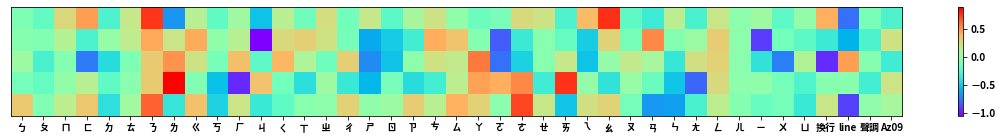

In [8]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']

w = np.array(model.layers[1].weights[0].value() ).T

plt.figure(figsize=(20, 2))
plt.imshow(w, cmap='rainbow')
plt.yticks([]); 
plt.xticks(range(41), [chr(i) for i in range(12549, 12586)] + ['換行', 'line', '聲調', 'Az09'])
plt.colorbar()

# 儲存模型

可以取消 train/test split 一樣做上面的 minibatch。應該會有更好的結果。

In [9]:
model.save('model/cnn.h5')

# 模型使用

In [ ]:
from keras.models import load_model
# model = load_model('model/cnn.h5')

# with open("data/bopomofo_ooxx.txt", "rb") as file:
#     X = pickle.load(file)
# X = np.array(X)
# pred = model.predict(to3Darray(X)).argmax(1)